In [1]:
import matplotlib.pyplot as plt
import os
import random
# external imports
import transformers
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
import torch
import torchvision
import time 
import numpy as np
from PIL import Image
import requests
import datasets
from datasets import load_dataset
from torchvision import datasets, transforms
from tqdm import tqdm
import cv2

# Intial Tests with DepthAnything


### DepthEstimation Example


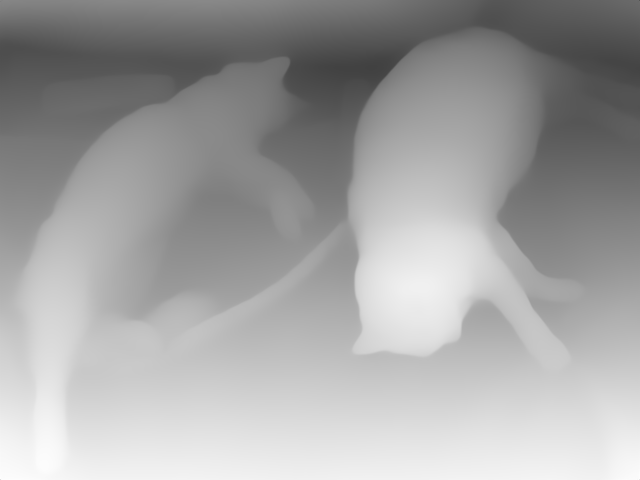

In [2]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

image_processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-small-hf")
model = AutoModelForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")

# prepare image for the model
inputs = image_processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

# interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

# visualize the prediction
output = prediction.squeeze().cpu().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)
depth

### Compute Budget Test

In [6]:
# import the dataset -> stream it so it does not take too long
train_dataset = load_dataset("sayakpaul/nyu_depth_v2", split="train", 
                                streaming = True, trust_remote_code=True)

# load the dataset into a dataloader
dataset = train_dataset.with_format("torch")
dataloader = torch.utils.data.DataLoader(dataset, num_workers=2, batch_size = 16)

image_processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-small-hf")
model = AutoModelForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
model.to(device)
# prepare image for the model
for i, batch in enumerate(tqdm(dataloader)):
    t0 = time.time()
    image = batch.get('image')
    inputs = image_processor(images=image, return_tensors="pt").to(device)
    inputs.to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        predicted_depth = outputs.predicted_depth

    # interpolate to original size
    prediction = torch.nn.functional.interpolate(
        predicted_depth.unsqueeze(1),
        size= [image.size()[1], image.size()[2]],#image.size(),
        mode="bicubic",
        align_corners=False,
    )

    # visualize the prediction
    # output = prediction.squeeze().cpu().numpy()
    # print(output)
    # formatted = (output * 255 / np.max(output)).astype("uint8")
    # depth = Image.fromarray(formatted)
    # plt.imshow(depth)
    print(f"The time taken is:{time.time()-t0}")

1it [00:55, 55.67s/it]

The time taken is:45.15743446350098


2it [01:39, 48.52s/it]

The time taken is:43.50679397583008


3it [02:22, 46.25s/it]

The time taken is:43.53765559196472


4it [03:06, 45.25s/it]

The time taken is:43.70222806930542


5it [03:50, 44.65s/it]

The time taken is:43.582024335861206


6it [04:33, 44.32s/it]

The time taken is:43.68479132652283


7it [05:17, 44.07s/it]

The time taken is:43.529057264328


8it [06:00, 43.96s/it]

The time taken is:43.72634553909302


9it [06:44, 43.86s/it]

The time taken is:43.63402533531189


10it [07:28, 43.81s/it]

The time taken is:43.70275902748108


11it [08:11, 43.73s/it]

The time taken is:43.54958415031433


12it [08:55, 43.73s/it]

The time taken is:43.721713066101074


13it [09:39, 43.72s/it]

The time taken is:43.68212056159973


14it [10:23, 43.77s/it]

The time taken is:43.86616373062134


15it [11:07, 44.01s/it]

The time taken is:44.57149314880371


16it [11:51, 43.90s/it]

The time taken is:43.63422679901123


17it [12:35, 43.86s/it]

The time taken is:43.771626234054565


18it [13:18, 43.82s/it]

The time taken is:43.72578239440918


19it [14:02, 43.79s/it]

The time taken is:43.68783903121948


20it [14:46, 43.76s/it]

The time taken is:43.68204689025879


21it [15:30, 43.81s/it]

The time taken is:43.92885732650757


22it [16:14, 43.82s/it]

The time taken is:43.818798780441284


23it [16:58, 43.98s/it]

The time taken is:44.3674681186676


24it [17:42, 44.09s/it]

The time taken is:44.31756830215454


25it [18:26, 44.02s/it]

The time taken is:43.86256170272827


26it [19:10, 44.11s/it]

The time taken is:44.30490303039551


27it [19:54, 44.03s/it]

The time taken is:43.84199523925781


28it [20:38, 43.94s/it]

The time taken is:43.73379707336426


29it [21:22, 43.84s/it]

The time taken is:43.59363412857056


30it [22:05, 43.82s/it]

The time taken is:43.74802923202515


31it [22:49, 43.75s/it]

The time taken is:43.589433431625366


32it [23:33, 43.73s/it]

The time taken is:43.67938852310181


33it [24:16, 43.67s/it]

The time taken is:43.50830793380737


34it [25:00, 43.67s/it]

The time taken is:43.653680086135864


35it [25:43, 43.63s/it]

The time taken is:43.53919959068298


36it [26:27, 43.62s/it]

The time taken is:43.592729806900024


37it [27:11, 43.65s/it]

The time taken is:43.709892988204956


38it [27:54, 43.64s/it]

The time taken is:43.59930181503296


39it [28:38, 43.62s/it]

The time taken is:43.58275055885315


40it [29:21, 43.59s/it]

The time taken is:43.50970149040222


40it [29:53, 44.83s/it]


KeyboardInterrupt: 

# Loading and Investigating Eiffel Tower Dataset

In [2]:
image_path = 'eiffel/2020/' #this is the path to the 2020 images
depth_path = 'eiffel/2020/depth/dense/' # this is the path to 2020 ground truth depths

transform = transforms.Compose([
    transforms.ToTensor()
])

In [5]:
dataset = datasets.ImageFolder(image_path, transform = transform)
dataloader = torch.utils.data.DataLoader(dataset, num_workers = 2, batch_size = 16)
sample = next(iter(dataloader))[0].numpy() # get one image
batch.shape

(16, 3, 1057, 1881)

In [9]:
sample = sample[0]

### Sampling one image and getting the depth

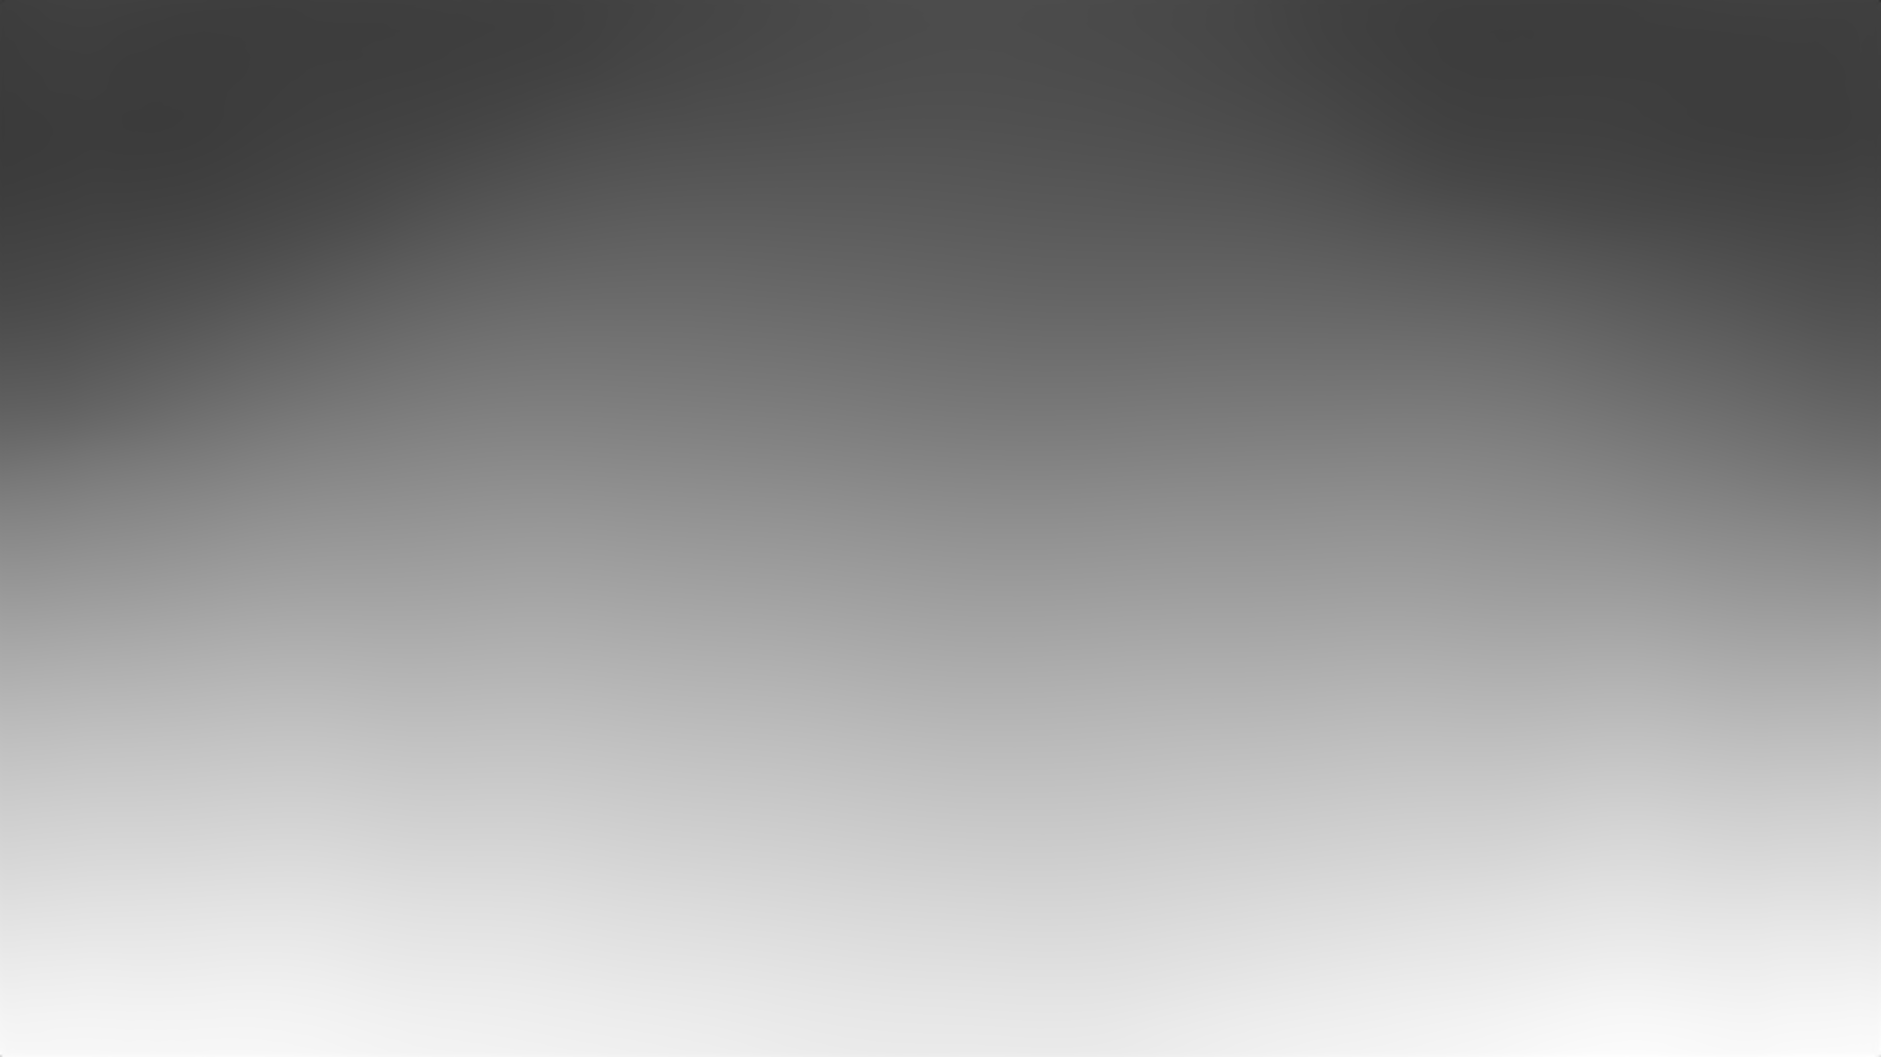

In [10]:
# image = Image.open(sample)

image_processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-small-hf")
model = AutoModelForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")

# prepare image for the model
inputs = image_processor(images=sample, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

# interpolate to original size 
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=[sample.shape[1], sample.shape[2]],
    mode="bicubic",
    align_corners=False,
)
# visualize the prediction
output = prediction.squeeze().cpu().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)
depth

We have a depth map! But it does not say much. Let's process a batch, and compare the images and the found depth map with the ground truth. Below is code from Madhu's test file that I plan to alter to fit our image files -> should not take too long. 
Then I will process the whole dataset and get some metrics. 

In [2]:
def min_max_normalize(image):
    # Get the minimum and maximum pixel values
    min_val = np.min(image)
    max_val = np.max(image)

    # Normalize the image
    normalized_image = (image - min_val) / (max_val - min_val)
    return normalized_image

In [14]:

def sample_eiffel_depth(image_path, depth_path, k, model, image_processor):
    # Get a list of all files in the directory
    image_files = os.listdir(image_path)

    # Shuffle the list of image files
    random.shuffle(image_files)

    # Select k random images
    selected_images = image_files[:k]

    # Create a grid to display the images
    fig, axes = plt.subplots(k, 3, figsize=(10, 2*k))

    for i, img_file in enumerate(selected_images):
        # Load the original image
        img_path = os.path.join(image_path, img_file)
        assert os.path.exists(img_path)

        original_image = Image.open(img_path)
        original_image_display = cv2.imread(img_path)

        img_lab = cv2.cvtColor(original_image_display,cv2.COLOR_BGR2Lab)
        l,a,b = cv2.split(img_lab)

        clahe = cv2.createCLAHE(clipLimit=50, tileGridSize=(8, 8))
        lumen_clahe = clahe.apply(l)
        equ = cv2.equalizeHist(l)

        updated_lab_img = cv2.merge((lumen_clahe,a,b))

        original_image_display = cv2.cvtColor(updated_lab_img,cv2.COLOR_LAB2LBGR)

        # Prepare image for the model
        inputs = image_processor(images=original_image, return_tensors="pt")

        with torch.no_grad():
            # Forward pass through the model
            outputs = model(**inputs)
            predicted_depth = outputs.predicted_depth

        # Interpolate to original size
        prediction = torch.nn.functional.interpolate(
            predicted_depth.unsqueeze(1),
            size=[np.array(original_image).shape[0], np.array(original_image).shape[1]],
            mode="bicubic",
            align_corners=False,
        )

        # Convert depth prediction to numpy array
        depth_output = prediction.squeeze().cpu().numpy()

        # Plot original image
        axes[i, 0].imshow(original_image)
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f'Image{i}',)

        # Plot depth output
        axes[i, 1].imshow(depth_output,cmap = 'plasma')
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f'Depth{i}')

        # Load ground truth depth from TIFF file
        depth_file = 'depth_' + img_file
        depths = os.path.join(depth_path, depth_file)
        depth_image = Image.open(depths)
        depth_array = np.array(depth_image)
        depth_normalized = min_max_normalize(depth_array)


        # Plot ground truth depth
        axes[i, 2].imshow(depth_normalized, cmap='plasma_r')
        axes[i, 2].axis('off')
        axes[i, 2].set_title(f'Ground Truth Depth {i}')
    plt.show()


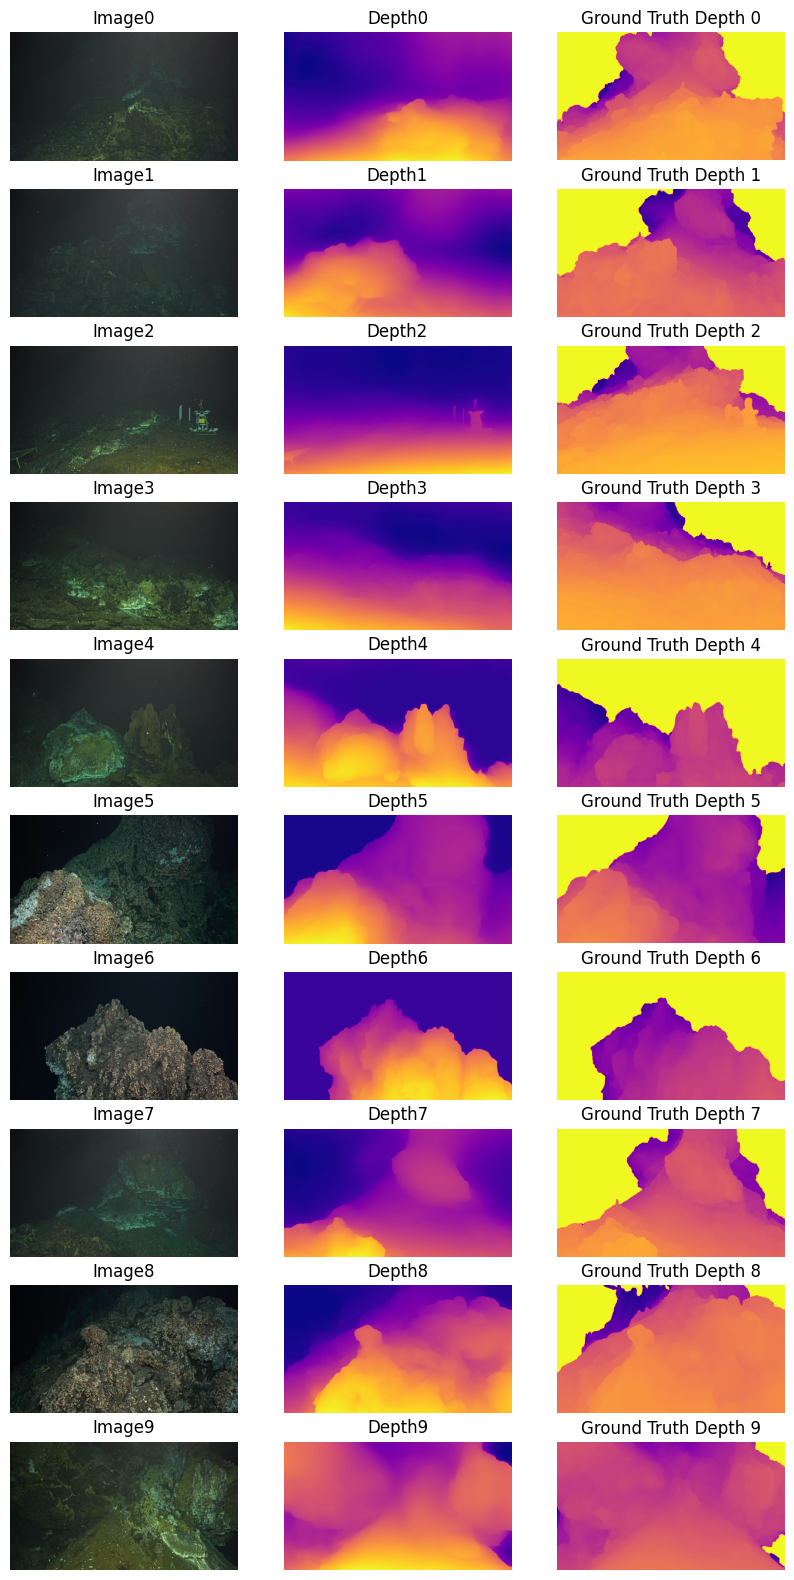

In [15]:
image_path = 'eiffel/2020/images/'
depth_path = 'eiffel/2020/depth/dense/depth'
image_processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-small-hf")
model = AutoModelForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")
sample_eiffel_depth(image_path, depth_path, 10, model, image_processor)

# Baseline Results -> No training

We can implement some basic metrics for getting baseline results for the entire dataset. DepthAnything used these metrics.

In [19]:
def absolute_relative_error(y_pred, y_true):
    """
    Calculate the Mean Absolute Relative Error (MARE).

    Parameters:
    y_pred : torch.Tensor
        Predicted depth values.
    y_true : torch.Tensor
        Ground truth depth values.

    Returns:
    float
        Mean Absolute Relative Error (MARE).
    """
    absolute_relative_error = np.abs(y_pred - y_true) / y_true
    return absolute_relative_error

In [12]:
def root_mean_squared_error(y_pred, y_true): 
    mse = np.mean((y_pred - y_true)**2)
    rmse = np.sqrt(mse)
    return rmse

In [5]:
def delta1_metric(y_pred, y_true, threshold=1.25):
    """
    Calculate the δ1 metric for monocular depth estimation.

    Parameters:
    y_pred : torch.Tensor
        Predicted depth values.
    y_true : torch.Tensor
        Ground truth depth values.
    threshold : float, optional
        Threshold for considering a pixel as correctly estimated (default is 1.25).

    Returns:
    float
        Percentage of pixels for which max(d*/d, d/d*) < threshold.
    """
    # Compute element-wise ratios
    ratio_1 = y_true / (y_pred + 1e-7)  # Adding epsilon to avoid division by zero
    ratio_2 = (y_pred + 1e-7) / y_true  # Adding epsilon to avoid division by zero
    
    # Calculate element-wise maximum ratio
    max_ratio = torch.max(ratio_1, ratio_2)
    
    # Count the number of pixels where max_ratio < threshold
    num_correct_pixels = torch.sum(max_ratio < threshold).item()
    
    # Calculate the percentage of pixels satisfying the condition
    total_pixels = y_true.numel()
    percentage_correct = (num_correct_pixels / total_pixels) * 100.0
    
    return percentage_correct

Let us now get the depths for the whole dataset, and compute baseline results for MAE and delta1. 

In [ ]:
# # utilise the gpu on the cluster 
# device = 'cuda' if torch.cuda.is_available() else 'cpu' 
# model.to(device)
# # prepare image for the model
# for i, batch in enumerate(tqdm(dataloader)):
#     image = batch.get('image')
#     inputs = image_processor(images=image, return_tensors="pt").to(device)
#     inputs.to(device)
#     with torch.no_grad():
#         outputs = model(**inputs)
#         predicted_depth = outputs.predicted_depth

#     # interpolate to original size
#     prediction = torch.nn.functional.interpolate(
#         predicted_depth.unsqueeze(1),
#         size=[sample.shape[1], sample.shape[2]],
#         mode="bicubic",
#         align_corners=False,
#     )

#     # visualize the prediction
#     output = prediction.squeeze().cpu().numpy()
#     normalised_out = min_max_normalize(output)
    

In [6]:
class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, label_dir, transforms=None):
        self.data_dir = data_dir
        self.transforms = transforms
        self.image_files = []
        self.mask_files = []
        
        for root, _, files in os.walk(data_dir):
            for file in files:
                if file.endswith('.jpg') or file.endswith('.png'):
                    image_file = os.path.join(root, file)
                    self.image_files.append(image_file)
                    
        for root, _, files in os.walk(label_dir):
            for file in files:
                if file.endswith('.jpg') or file.endswith('.png'):
                    mask_file = os.path.join(root, file)
                    self.mask_files.append(mask_file)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        image_file = self.image_files[index]
        mask_file = self.mask_files[index]
        
        image = Image.open(image_file).convert('RGB')
        mask = Image.open(mask_file)
        
        if self.transforms:
            image = self.transforms(image)
            mask = self.transforms(mask)
        
        return image, mask

# Define the data transformations
data_transforms = transforms.Compose([
    #transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Resize((1080, 1920))
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the data
train_data = SegmentationDataset('eiffel/2020/images/','eiffel/2020/depth/dense/depth', transforms=data_transforms)
# test_data = SegmentationDataset('eiffel/2020/depth/dense/depth', transforms=data_transforms)

# Create data loaders
batch_size = 16
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [21]:
#https://huggingface.co/docs/transformers/main/en/preprocessing#computer-vision
def evaluate_model(model, dataloader):
    model.eval()
    mae = 0
    delta1 = 0
    total = 0
    rmse = 0
    i = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    for data, labels in dataloader:
        if i == 1:
            break
        inputs = image_processor(images=data, return_tensors="pt", do_rescale= False).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            predicted_depth = outputs.predicted_depth
            # interpolate to original size
            prediction = torch.nn.functional.interpolate(
                predicted_depth.unsqueeze(1),
                size=[data.shape[2], data.shape[3]],
                mode="bicubic",
                align_corners=False,
            )

            # visualize the prediction
            output = prediction.squeeze().cpu().numpy()
            normalized_out = min_max_normalize(output)
            labels_normalized = min_max_normalize(labels.squeeze().numpy())
            
            print(labels_normalized[0])
            print(normalized_out[0])

            # Create a mask for non-zero values in labels
            mask = labels_normalized != 0
            
            # Apply the mask to both predictions and labels
            normalized_out_masked = normalized_out[mask]
            labels_normalized_masked = labels_normalized[mask]
            
            mae += absolute_relative_error(normalized_out_masked, labels_normalized_masked)
            rmse += root_mean_squared_error(normalized_out_masked, labels_normalized_masked)
            
            out_t = torch.from_numpy(normalized_out_masked)
            labels_t = torch.from_numpy(labels_normalized_masked)
            
            delta1 += delta1_metric(out_t, labels_t )
            total += data.size(0)
            i+=1
        
    total_mae = np.sum(mae)/total
    total_delta = np.sum(delta1)/total
    total_rmse = np.sum(rmse)/total
  
    return total_mae, total_delta, total_rmse
    
image_processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-small-hf")
model = AutoModelForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")   
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
model.to(device)

#batch2 = next(iter(img_dataloader)).numpy()
#batch2
result = evaluate_model(model, train_loader)
result

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0.13788241 0.13674855 0.13473031 ... 0.03800078 0.03800078 0.03800078]
 [0.13633907 0.13577844 0.13475168 ... 0.03800078 0.03800078 0.03800078]
 [0.13351373 0.1339762  0.13471726 ... 0.03800078 0.03800078 0.03800078]
 ...
 [0.3001878  0.3019708  0.3049523  ... 0.09583347 0.10274585 0.10680561]
 [0.2813142  0.2882877  0.30022493 ... 0.10441239 0.11000765 0.11331397]
 [0.27045655 0.28041133 0.29749104 ... 0.10946077 0.11435528 0.117262  ]]


(1996271.721093096, 0.6413959935562941, 0.015534867692254616)

Current Issues:
- labels have different representations of close/far
- may need to convert labels to metres 

In [34]:
depth_dataset

Dataset ImageFolder
    Number of datapoints: 3977
    Root location: eiffel/2020/depth/dense/
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [35]:
img_dataset

Dataset ImageFolder
    Number of datapoints: 5587
    Root location: eiffel/2020/
    StandardTransform
Transform: Compose(
               ToTensor()
           )